<a href="https://colab.research.google.com/github/alexanderimanicowenrivers/TF-Pruning/blob/master/MNIST_Prune_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro 

In this colab document we will explore how to create and prune a basic model in tensorflow.


# Imports & utils

In [1]:
from __future__ import print_function
import keras
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.eager as tfe
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Plot learning curves of experiments
def plot_learning_curves(results):
    """
    Returns learning curves.
    :param results: List of list. results frome each experiment.
    """
    fig, axes = plt.subplots(1, 3, figsize=(22,12))
    st = fig.suptitle(
      "Learning Curves for all Tasks and Hyper-parameter settings",
      fontsize="x-large")
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
        xs = [x * log_period_samples for x in range(1, len(train_accuracy)+1)]
        axes[j].plot(xs, train_accuracy, label='train_accuracy')
        axes[j].plot(xs, test_accuracy, label='val_accuracy')
        axes[j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[j].set_xlabel('Number of samples processed')
        axes[j].set_ylabel('Epochs: {}, Learning rate: {}.  Accuracy'.format(*setting))
        axes[j].set_title('Settings {}'.format(j + 1))
        axes[j].legend()
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.91)
    plt.show()

def plot_pruning_curves(results,fine_tune='w/o'):
    """
    Returns pruning curves, sparsity against accuracy. 
    :param results: List of list. results frome each experiment.
    """
    fig, axes = plt.subplots(1, 2, figsize=(22,12))
    setting=['weight','unit']
    st = fig.suptitle(
      "Pruning Methods Accuracy Curves",
      fontsize="x-large")    
    for j, (train_accuracy) in enumerate(results):
    # Plot.
        xs = [x * (1/len(train_accuracy)) for x in range(0, len(train_accuracy))]
        axes[j].plot(xs, train_accuracy, label='test_accuracy')
        axes[j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[j].set_xlabel('Sparsity level k')
        axes[j].set_ylabel('Accuracy'.format(setting[j]))
        axes[j].set_title(f'Prune type: {setting[j]} {fine_tune} fine-tuning')
        axes[j].legend()
    fig.subplots_adjust(top=0.91)
    plt.show()

# Data loader

In [0]:
# Global variables.
log_period_samples = 2000
batch_size = 1000

In [0]:
def get_data():
    """
    Returns mnist data. 
    """
    return input_data.read_data_sets("MNIST_data/", one_hot=True)

In [5]:
mnist=get_data()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
# Use a tuple (num_epochs, learning_rate) as expriment setting 
settings = [(10, 0.01),(10, 0.005),(10, 0.001)]

# Model

In [0]:
weight_default_name = 'weight'
mask_default_name = 'mask'


def get_placeholders():
    """
    Returns placeholds for input and target.
    :param initializer: TensorFlow initializer. Default Xavier.
    :param layer: Variable layer number.
    """
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])
    return x, y_


def _weight_variable(
        shape,
        initializer=None,
        name=None,
        layer_no=0,
        train_bool=True
):
    """
    Returns a weight variable with a given shape.
    :param shape: var shape.
    :param initializer: TensorFlow initializer. Default Xavier.
    :param name: Variable name.
    :param layer: Variable layer number.
    """
    if name == weight_default_name:
        name = weight_default_name + '_' + str(layer_no)

    if initializer is None:
        initializer = tf.contrib.layers.xavier_initializer()
    var = tf.get_variable(name, shape, initializer=initializer, trainable=train_bool)
    return var


def _mask_variable(
        shape,
        initializer=None,
        layer_no=0, train_bool=False,
):
    """
    Returns a mask variable with a given shape.
    :param shape: Variable shape.
    :param initializer: TensorFlow initializer. Default zero.
    :param layer_no: Variable layer number.
    """
    name = mask_default_name + '_' + str(layer_no)
    if initializer is None:
        initializer = tf.constant_initializer(1.)
    return _weight_variable(shape,
                            initializer=initializer,
                            name=name, train_bool=False)


def affine(
        inp,
        units,
        W_initializer=None,
        b_initializer=None,
        W_name=weight_default_name,
        bias_name=mask_default_name,
        layer_no=0,
):
    """ Creates an affine layer. Returns Tensor defined as input.dot(weight)*mask.
    :param inp: Input tensor.
    :param units: Number of units.
    :param W_initializer: Initializer for the multiplicative weight.
    :param b_initializer: Initializer for the bias term.
    :param W_name: Name of the weight.
    :param bias_name: Name of the bias.
    :param layer_no: Variable layer number.
    """
    input_size = inp.shape[-1]
    W = _weight_variable([input_size, units],
                         initializer=W_initializer,
                         name=W_name, layer_no=layer_no)

    m_variable = _mask_variable([input_size, units],
                                initializer=b_initializer,
                                layer_no=layer_no, train_bool=False)
    W = tf.multiply(W, m_variable)
    output = tf.matmul(inp, W)

    return output


def mlp(inputs,
        layer_sizes,
        nonlinearity=tf.nn.relu,
        output_nonlinearity=None,
        W_initializer=None,
        b_initializer=None):
    """
    Creates a multi-layer perceptron with given hidden sizes. A nonlinearity
    is applied after every hidden layer. Return final layer logits from MLP:

    output shape: N x (number of output units)
    :param inputs: List of input tensors.
    :param layer_sizes: List of layers sizes, including output layer size.
    :param nonlinearity: Hidden layer nonlinearity.
    :param output_nonlinearity: Output layer nonlinearity.
    :param W_initializer: Weight initializer.
    :param b_initializer: Bias initializer.
    """
    if layer_sizes[-1] is None:
        layer_sizes = list(layer_sizes)
        layer_sizes[-1] = 1

    # Take care of the input layer separately to make use of broadcasting in
    # a case of several input tensors.
    layer = affine(
        inp=inputs,
        units=layer_sizes[0],
        W_initializer=W_initializer,
        b_initializer=b_initializer
    )

    layer = nonlinearity(layer)

    for i_layer, size in enumerate(layer_sizes[1:], 1):
        layer = affine(layer, size,
                       W_initializer=W_initializer,
                       b_initializer=b_initializer,
                       layer_no=i_layer)
        if i_layer < len(layer_sizes) - 1:
            layer = nonlinearity(layer)

    return layer


def get_graph(layers):
    """
    Creates tensorflow graph.
    :param layer: List of layer sizes. 
    """
    x, y_ = get_placeholders()
    linear = mlp(x, layers)
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=linear, labels=y_))
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(linear, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return x, y_, linear, loss, opt, correct_prediction, accuracy


layers = [1000, 1000, 500, 200, 10]  # as given in the doc

# Training

In [8]:
experiments_task1 = []
print('Training Model 1')
# Train Model 1 with the different hyper-parameter settings.
for (num_epochs, learning_rate) in settings:
  
  # Reset graph, recreate placeholders and dataset.
  tf.reset_default_graph()
  mnist = get_data()
  eval_mnist = get_data()
  
  mask1=np.zeros((784, 1000),dtype=np.float32)
  mask2=np.zeros((1000,1000),dtype=np.float32)
  mask3=np.zeros((1000,500),dtype=np.float32)
  mask4=np.zeros((500,200),dtype=np.float32)
   
  #####################################################
  # Define model, loss, update and evaluation metric. #
  #####################################################
  x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
  # Train.
  i, train_accuracy, test_accuracy = 0, [], []
  log_period_updates = int(log_period_samples / batch_size)
  saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(f'{tf.trainable_variables()}')
    total_parameters=0
    for variable in tf.trainable_variables():
      # shape is an array of tf.Dimension
      shape = variable.get_shape()
      variable_parameters = 1
      for dim in shape:
          variable_parameters *= dim.value
      total_parameters += variable_parameters
    while mnist.train.epochs_completed < num_epochs:

      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)
      
      #################
      # Training step #
      #################
      feed_dict={x:batch_xs,y_:batch_ys}
      _=sess.run([opt],feed_dict=feed_dict)
      
      # Periodically evaluate.
      if i % log_period_updates == 0:
        
        #####################################
        # Compute and store train accuracy. #
        #####################################
        
        batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
        
        feed_dict={x:batch_xs,y_:batch_ys}
        acc=sess.run([accuracy],feed_dict)
        print(f'Accuracy {acc} at iteration {i}')

        train_accuracy.append(acc[0])
        #####################################
        # Compute and store test accuracy.  #
        #####################################

        feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
        acc=sess.run([accuracy],feed_dict)
        test_accuracy.append(acc[0])
        print(f'Validation Accuracy {acc[0]}')
    save_path = saver.save(sess, "./tmp/model.ckpt")
    experiments_task1.append(
        ((num_epochs, learning_rate), train_accuracy, test_accuracy))

Training Model 1
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[<tf.Variable 'weight_0:0' shape=(784, 1000) dtype=float32_ref>, <tf.Variable 'weight_1:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'weight_2:0' shape=(1000, 500) dtype=float32_ref>, <tf.Variable 'weight_3:0' shape=(500, 200) dtype=float32_ref>, <tf.Variable 'weight_4:0' shape=(200, 10) dtype=float32_ref>]
Accuracy [0.11763636] at iteration 2
Validation Accuracy 0.11990000307559967
Accuracy

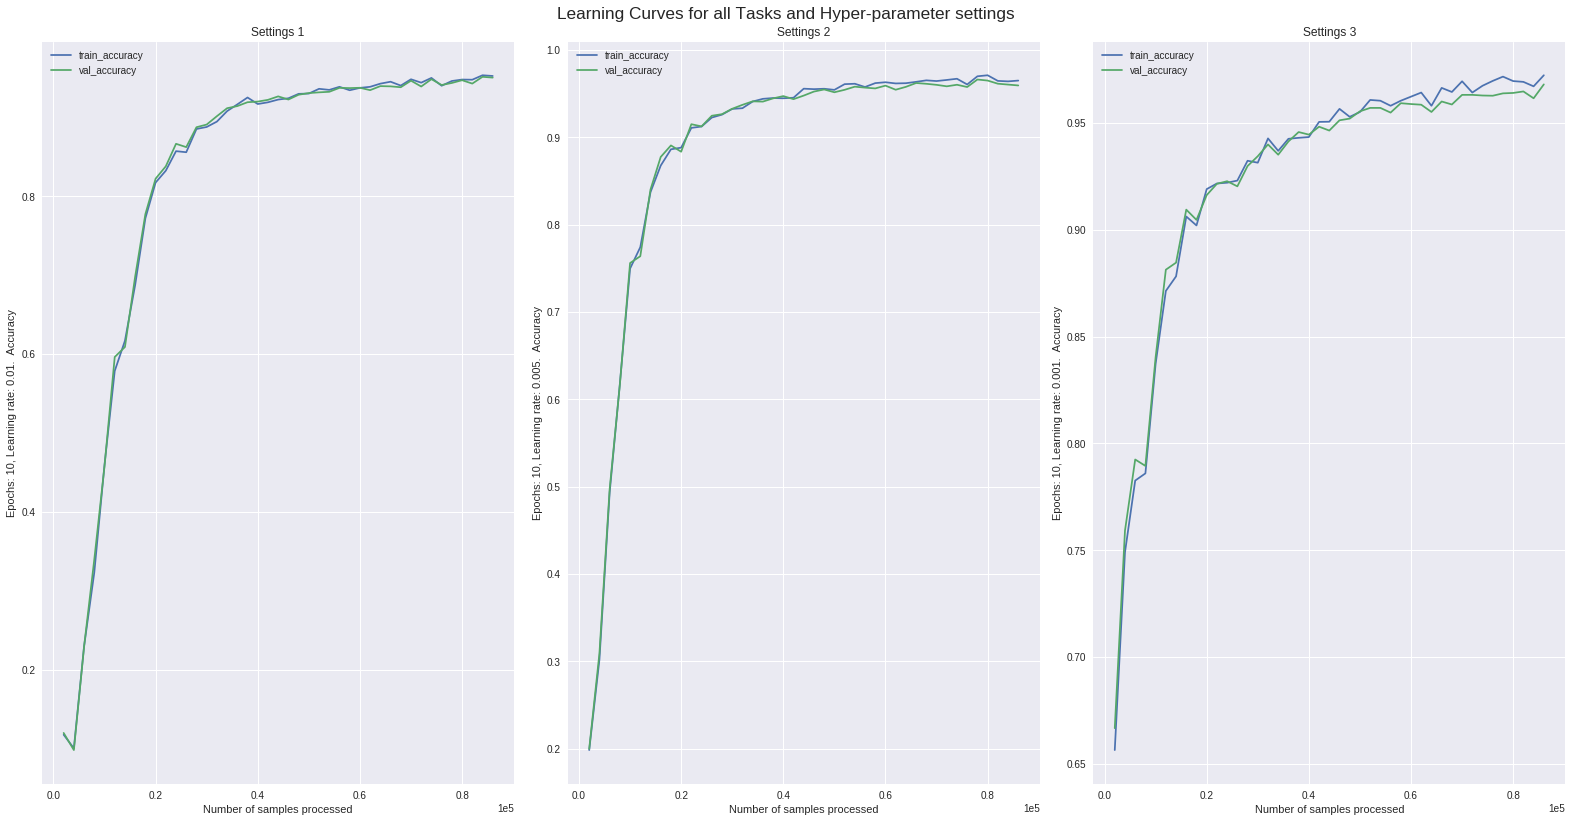

In [9]:
plot_learning_curves(experiments_task1)

# Test: Restore

In [0]:
num_epochs=1
learning_rate=0.001
mnist = get_data()
eval_mnist = get_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./tmp/model.ckpt")
    print("Model restored.")
    # Check the values of the variables
    batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
    feed_dict={x:batch_xs,y_:batch_ys}
    acc=sess.run([accuracy],feed_dict)
    total_parameters=0
    restore_var_list=[]
    for variable in tf.trainable_variables():
        restore_var_list.append(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
            total_parameters += variable_parameters
    print("total parameters: passed test",total_parameters)


INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Model restored.
total parameters: passed test 2389484


# Pruning

Unit pruning - Han, S., Pool, J., Tran, J. and Dally, W., 2015. Learning both weights and connections for efficient neural network. In Advances in neural information processing systems (pp. 1135-1143).

Weight pruning - LeCun, Y., Denker, J.S. and Solla, S.A., 1990. Optimal brain damage. In Advances in neural information processing systems (pp. 598-605).

In [0]:
k=[25, 50, 60, 70, 80, 90, 95, 97, 99]
type_prunes=['weight','unit']

In [0]:
import time

In [0]:
def return_variable_names_sizes():
    """
    Returns variable names and sizes.
    """
    all_vars = []
    var_sizes = []
    mask_vars = []
    for variable in tf.trainable_variables():
        if 'weight' in variable.name:
            var_sizes.append(variable.shape)
            all_vars.append(variable)

    for variable in tf.global_variables():
        if 'mask' in variable.name:
            mask_vars.append(variable)
    return all_vars,var_sizes,mask_vars

def create_masks(var_sizes):
    """
    Returns hidden layer pruning masks for all but the final layer. 
    :param var_sizes: sizes of weight variables. 
    """
    mask1 = np.ones(var_sizes[0]) * 1.0
    mask2 = np.ones(var_sizes[1]) * 1.0
    mask3 = np.ones(var_sizes[2]) * 1.0
    mask4 = np.ones(var_sizes[3]) * 1.0
    
    return [mask1,mask2,mask3,mask4]

def prune_type_batch(type_prune='unit'):
    """
    Returns batch size depending on prune type, so that pruning is completed at <=1% sparsity intervals. 
    """
    if type_prune == 'unit':
        batch_k = 25  # how many columns to prune per each prune iteration
    else:
        batch_k = 23860  # how many weights at a time
    return batch_k

def calculate_prune_rank(all_vars,type_prune,masks):
    """
    Returns cumulative sum of type_prune in each layer and prune rank of type_prune.
    :param all_vars: List of weight variables for pruning.
    :param type_prune: Prune type, 'unit' or 'weight'.
    """
    # Prune measures used to rank unit/ weights: l2 norm for unit and l1 for weight.
    # 0) Compute Ranks, as we do not fine-tune this can be pre-computed

    var_mag = np.array([])
    layer_sizes = []
    var_num=0
    for variable in all_vars[:-1]:
        if type_prune == 'unit':
            layer_sizes.append(variable.shape[1].value)
            unit_vals = (tf.norm(variable*masks[var_num], axis=0).eval())
            var_mag = np.concatenate((var_mag, unit_vals), axis=0)
        else:
            layer_sizes.append(variable.shape[0].value * variable.shape[1].value)  # each individual weight
            weight_vals = tf.reshape(tf.abs(variable*masks[var_num]), [-1]).eval()
            var_mag = np.concatenate((var_mag, weight_vals), axis=0)
        var_num+=1 

    cum_sum_ind = np.cumsum(layer_sizes)
    all_concat = np.reshape(np.array(var_mag), ((-1,)))
    prune_rank = np.sort(all_concat)

    return cum_sum_ind,prune_rank


def calculate_pruned_masks(batch_k,k,prune_rank,cum_sum_ind,params_pruned,masks):
    """
    Returns masks with selected units or weight values zeroed.
    :param batch_k: Number of weights or units to be pruned/ zeroed out. 
    :param k: The step of pruning we are now in.
    :param prune_rank: Sorted rank of weights or units to be pruned .
    :param cum_sum_ind: Cumulative sum of weights or units.
    :param params_pruned: total parameters pruned, for logging.
    :param masks: variable masks.
    """
    sparse_before = int((k - 1) * batch_k)
    partion_k = int(batch_k * k)
    
    mask1=masks[0]
    mask2=masks[1]
    mask3=masks[2]
    mask4=masks[3]

    prune_indxss = prune_rank[sparse_before:partion_k]  # first k guaranteed to be the lowest index's
    prune_indxs = np.array([np.where(prune_rank == i)[0][0] for i in prune_indxss])

    # 2) Pruning

    ly1 = prune_indxs[~(prune_indxs >= cum_sum_ind[0])]
    prune_indxs = prune_indxs[~(prune_indxs < cum_sum_ind[0])]
    ly2 = prune_indxs[~(prune_indxs >= cum_sum_ind[1])]
    prune_indxs = prune_indxs[~(prune_indxs < cum_sum_ind[1])]
    ly3 = prune_indxs[~(prune_indxs >= cum_sum_ind[2])]
    prune_indxs = prune_indxs[~(prune_indxs < cum_sum_ind[2])]
    ly4 = prune_indxs[~(prune_indxs >= cum_sum_ind[3])]

    ly2 = ly2 - cum_sum_ind[0]
    ly3 = ly3 - cum_sum_ind[1]
    ly4 = ly4 - cum_sum_ind[2]

    if type_prune == 'unit':
        mask1[:, ly1] = 0
        mask2[:, ly2] = 0
        mask3[:, ly3] = 0
        mask4[:, ly4] = 0
        params_pruned += ly1.shape[0] * (all_vars[0].shape[0].value) + ly2.shape[0] * (
            all_vars[1].shape[0].value) + ly3.shape[0] * (all_vars[2].shape[0].value) + ly4.shape[0] * (
                             all_vars[3].shape[0].value)

    else:
        i_idx1 = (ly1 / var_sizes[0][1].value).astype(int)
        j_idx1 = (ly1 % var_sizes[0][1].value).astype(int)
        i_idx2 = (ly2 / var_sizes[1][1].value).astype(int)
        j_idx2 = (ly2 % var_sizes[1][1].value).astype(int)
        i_idx3 = (ly3 / var_sizes[2][1].value).astype(int)
        j_idx3 = (ly3 % var_sizes[2][1].value).astype(int)
        i_idx4 = (ly4 / var_sizes[3][1].value).astype(int)
        j_idx4 = (ly4 % var_sizes[3][1].value).astype(int)

        mask1[i_idx1, j_idx1] = 0
        mask2[i_idx2, j_idx2] = 0
        mask3[i_idx3, j_idx3] = 0
        mask4[i_idx4, j_idx4] = 0

        params_pruned += batch_k
        
    return mask1,mask2,mask3,mask4,params_pruned


## Pruning withouth fine-tuning

In [0]:
tf.reset_default_graph()
x, y_, linear, loss, opt, correct_prediction, accuracy = get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs = []
params = []
avg_inference_times = []
with tf.Session() as sess:
    param_prune_count = []
    all_vars, var_sizes, mask_vars=return_variable_names_sizes()
    
    for type_prune in type_prunes:
        acc_list = []
        saver.restore(sess, "./tmp/model.ckpt")
        print("Model restored.")
        params_pruned = 0.
        k = 1
        masks=create_masks(var_sizes)
        batch_k=prune_type_batch(type_prune=type_prune)
        cum_sum_ind, prune_rank=calculate_prune_rank(all_vars, type_prune,masks)

        while (params_pruned / total_parameters) < 0.99:  # continue to 99% sparsity 
            # 1) Evaluate
            feed_dict = {x: eval_mnist.test.images, y_: eval_mnist.test.labels}
            t_before = time.time()
            acc = sess.run(accuracy, feed_dict)
            t_after = time.time()
            avg_inference_times.append(t_after - t_before)
            
            # 2) Prune 
            mask1,mask2,mask3,mask4,params_pruned=calculate_pruned_masks(batch_k,k,prune_rank,cum_sum_ind,params_pruned,masks)
            assign_op = [mask_vars[0].assign(mask1)]  
            assign_op += [mask_vars[1].assign(mask2)]
            assign_op += [mask_vars[2].assign(mask3)]
            assign_op += [mask_vars[3].assign(mask4)]
            sess.run(assign_op)
            param_prune_count.append(params_pruned / total_parameters)
            acc_list.append(acc)
            print(f"paramns pruned {params_pruned}, \
            k={params_pruned/total_parameters*1.0} sparsity level and acc is {acc}")
            k += 1
            
        accs.append([acc_list])
        params.append(param_prune_count)
        print(f'average inf time {np.mean(np.array(avg_inference_times))}')
        
    save_path = saver.save(sess, "./tmp/model_sparse.ckpt")

## Pruning with fine-tuning

In [0]:
tf.reset_default_graph()
x, y_, linear, loss, opt, correct_prediction, accuracy = get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs2 = []
params = []
avg_inference_times = []
with tf.Session() as sess:
    param_prune_count = []
    all_vars, var_sizes, mask_vars=return_variable_names_sizes()
    
    for type_prune in type_prunes:  
        acc_list = []
        saver.restore(sess, "./tmp/model.ckpt")
        print("Model restored.")
        params_pruned = 0.
        k = 1
        masks=create_masks(var_sizes)
        batch_k=prune_type_batch(type_prune=type_prune)

        while (params_pruned / total_parameters) < 0.99:  # continue to 99% sparsity 
            #0 Re-calculate unit/ weight ranks     
            cum_sum_ind, prune_rank=calculate_prune_rank(all_vars, type_prune,masks)

            # 1) Evaluate
            feed_dict = {x: eval_mnist.test.images, y_: eval_mnist.test.labels}
            t_before = time.time()
            acc = sess.run(accuracy, feed_dict)
            t_after = time.time()
            avg_inference_times.append(t_after - t_before)
            
            # 2) Prune 
            mask1,mask2,mask3,mask4,params_pruned=calculate_pruned_masks(batch_k,k,prune_rank,cum_sum_ind,params_pruned,masks)
            assign_op = [mask_vars[0].assign(mask1)]  
            assign_op += [mask_vars[1].assign(mask2)]
            assign_op += [mask_vars[2].assign(mask3)]
            assign_op += [mask_vars[3].assign(mask4)]
            sess.run(assign_op)
            param_prune_count.append(params_pruned / total_parameters)
            acc_list.append(acc)
            print(f"paramns pruned {params_pruned}, \
            k={params_pruned/total_parameters*1.0} sparsity level and acc is {acc}")
            k += 1
            
            # 3) train 
            mnist.train._epochs_completed = 0
            mnist.train._index_in_epoch = 0
            while mnist.train.epochs_completed < num_epochs:
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                feed_dict={x:batch_xs,y_:batch_ys}
                _=sess.run([opt],feed_dict=feed_dict)
            b
        accs2.append([acc_list])
        params.append(param_prune_count)
        print(f'average inf time {np.mean(np.array(avg_inference_times))}')
        
#     save_path = saver.save(sess, "./tmp/model_sparse.ckpt")

2389484 Total parameters to prune
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Model restored.
paramns pruned 23860.0,             k=0.009985419446206796 sparsity level and acc is 0.9635999798774719
paramns pruned 47720.0,             k=0.019970838892413592 sparsity level and acc is 0.9750000238418579
paramns pruned 71580.0,             k=0.029956258338620388 sparsity level and acc is 0.9745000004768372
paramns pruned 95440.0,             k=0.039941677784827184 sparsity level and acc is 0.977400004863739
paramns pruned 119300.0,             k=0.04992709723103398 sparsity level and acc is 0.9790999889373779
paramns pruned 143160.0,             k=0.059912516677240776 sparsity level and acc is 0.980400025844574
paramns pruned 167020.0,             k=0.06989793612344758 sparsity level and acc is 0.9789000153541565
paramns pruned 190880.0,             k=0.07988335556965437 sparsity level and acc is 0.9764999747276306
paramns pruned 214740.0,             k=0.08986877501586117 s

paramns pruned 1884940.0,             k=0.7888481362503369 sparsity level and acc is 0.7664999961853027
paramns pruned 1908800.0,             k=0.7988335556965437 sparsity level and acc is 0.7688000202178955
paramns pruned 1932660.0,             k=0.8088189751427505 sparsity level and acc is 0.7275999784469604
paramns pruned 1956520.0,             k=0.8188043945889573 sparsity level and acc is 0.7236999869346619
paramns pruned 1980380.0,             k=0.828789814035164 sparsity level and acc is 0.7063999772071838
paramns pruned 2004240.0,             k=0.8387752334813708 sparsity level and acc is 0.7153000235557556
paramns pruned 2028100.0,             k=0.8487606529275776 sparsity level and acc is 0.7240999937057495
paramns pruned 2051960.0,             k=0.8587460723737844 sparsity level and acc is 0.6431000232696533
paramns pruned 2075820.0,             k=0.8687314918199912 sparsity level and acc is 0.6435999870300293
paramns pruned 2099680.0,             k=0.8787169112661981 sparsi

paramns pruned 1234000.0,             k=0.5164294885422962 sparsity level and acc is 0.09799999743700027
paramns pruned 1259000.0,             k=0.5268919984398305 sparsity level and acc is 0.09799999743700027
paramns pruned 1284000.0,             k=0.5373545083373649 sparsity level and acc is 0.09799999743700027
paramns pruned 1309000.0,             k=0.5478170182348993 sparsity level and acc is 0.09799999743700027
paramns pruned 1334000.0,             k=0.5582795281324336 sparsity level and acc is 0.09799999743700027
paramns pruned 1359000.0,             k=0.5687420380299679 sparsity level and acc is 0.09799999743700027
paramns pruned 1384000.0,             k=0.5792045479275023 sparsity level and acc is 0.09799999743700027
paramns pruned 1409000.0,             k=0.5896670578250367 sparsity level and acc is 0.09799999743700027
paramns pruned 1434000.0,             k=0.6001295677225711 sparsity level and acc is 0.09799999743700027
paramns pruned 1459000.0,             k=0.6105920776201

InvalidArgumentError: Cannot serialize protocol buffer of type tensorflow.GraphDef as the serialized size (3948444479bytes) would be larger than the limit (2147483647 bytes)

In [0]:
tf.reset_default_graph()
x, y_, linear, loss, opt, correct_prediction, accuracy = get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs2 = []
params = []
avg_inference_times = []
with tf.Session() as sess:
    param_prune_count = []
    all_vars, var_sizes, mask_vars=return_variable_names_sizes()
    
    acc_list = []
    saver.restore(sess, "./tmp/model.ckpt")
    print("Model restored.")
    params_pruned = 0.
    k = 1
    batch_k=prune_type_batch(type_prune=type_prune)

    mask1,mask2,mask3,mask4,params_pruned=calculate_pruned_masks(batch_k,k,prune_rank,cum_sum_ind,params_pruned,masks)
    assign_op = [mask_vars[0].assign(mask1)]  
    assign_op += [mask_vars[1].assign(mask2)]
    assign_op += [mask_vars[2].assign(mask3)]
    assign_op += [mask_vars[3].assign(mask4)]
    sess.run(assign_op)
    save_path = saver.save(sess, "./tmp/model_sparse.ckpt")

# Extra: Utilise sparsity

In [0]:
def sparse_mlp(all_weights,mask_vars,var_sizes):
    """
    Returns mlp which utilises sparse multiplication. 
    :param all_weights: List, all variables. 
    :param var_sizes: List, all variable sizes.
    :param mask_vars: List, all variable masks.
    """    
        
    mask_vars[0]=tf.transpose(mask_vars[0])
    mask_vars[1]=tf.transpose(mask_vars[1])
    mask_vars[2]=tf.transpose(mask_vars[2])
    mask_vars[3]=tf.transpose(mask_vars[3])

    ### BUG - only get unit dimensions, not getting input valeyes 
    all_weights[0]=tf.reshape(tf.transpose(all_weights[0])*mask_vars[0],[-1])
    all_weights[1]=tf.reshape(tf.transpose(all_weights[1])*mask_vars[1],[-1])
    all_weights[2]=tf.reshape(tf.transpose(all_weights[2])*mask_vars[2],[-1])
    all_weights[3]=tf.reshape(tf.transpose(all_weights[3])*mask_vars[3],[-1])
    all_weights[4]=tf.cast(all_weights[4], dtype=np.float64)
    zero = tf.constant(0., dtype=tf.float32)
    
    where_w1 = tf.not_equal(mask_vars[0], zero)
    where_w1_flat = tf.where(tf.not_equal(all_weights[0], zero))
    sparse_indx_w1 = np.asarray(tf.where(where_w1).eval(), dtype=np.int64)

    where_w2 = tf.not_equal(mask_vars[1], zero)
    where_w2_flat = tf.where(tf.not_equal(all_weights[1], zero))
    sparse_indx_w2 = np.asarray(tf.where(where_w2).eval(), dtype=np.int64)
    
    where_w3 = tf.not_equal(mask_vars[2], zero)
    where_w3_flat = tf.where(tf.not_equal(all_weights[2], zero))
    sparse_indx_w3 = np.asarray(tf.where(where_w3).eval(), dtype=np.int64)
    
    where_w4 = tf.not_equal(mask_vars[3], zero)
    where_w4_flat = tf.where(tf.not_equal(all_weights[3], zero))
    sparse_indx_w4 = np.asarray(tf.where(where_w4).eval(), dtype=np.int64)
    
    vals_w1=np.asarray(tf.squeeze(tf.gather(all_weights[0], where_w1_flat)).eval(), dtype=np.float64)
    vals_w2=np.asarray(tf.squeeze(tf.gather(all_weights[1], where_w2_flat)).eval(), dtype=np.float64)
    vals_w3=np.asarray(tf.squeeze(tf.gather(all_weights[2], where_w3_flat)).eval(), dtype=np.float64)
    vals_w4=np.asarray(tf.squeeze(tf.gather(all_weights[3], where_w4_flat)).eval(), dtype=np.float64)
    
    var_sizes[0]=np.asarray([var_sizes[0][1].value,var_sizes[0][0].value], dtype=np.int64)
    var_sizes[1]=np.asarray([var_sizes[1][1].value,var_sizes[1][0].value], dtype=np.int64)
    var_sizes[2]=np.asarray([var_sizes[2][1].value,var_sizes[2][0].value], dtype=np.int64)
    var_sizes[3]=np.asarray([var_sizes[3][1].value,var_sizes[3][0].value], dtype=np.int64)

    #[units,input_dims]    
    sparse_w1=tf.SparseTensor(indices=sparse_indx_w1, values=vals_w1, dense_shape=var_sizes[0])
    sparse_w2=tf.SparseTensor(indices=sparse_indx_w2, values=vals_w2, dense_shape=var_sizes[1])
    sparse_w3=tf.SparseTensor(indices=sparse_indx_w3, values=vals_w3, dense_shape=var_sizes[2])
    sparse_w4=tf.SparseTensor(indices=sparse_indx_w4, values=vals_w4, dense_shape=var_sizes[3])

    x_t = tf.placeholder(tf.float64, [784,None])    
    y = tf.placeholder(tf.float32, [None, 10])
    h1=tf.nn.relu(tf.sparse.matmul(sparse_w1,x_t)) #output is a dense matrix 
    h2=tf.nn.relu(tf.sparse.matmul(sparse_w2,h1))
    h3=tf.nn.relu(tf.sparse.matmul(sparse_w3,h2))
    h4=tf.nn.relu(tf.sparse.matmul(sparse_w4,h3))
      
    h4_t=tf.transpose(h4)
    linear=tf.matmul(h4_t,all_weights[4]) #[batch_size,10]
    
    #accuracy 
    
    correct_prediction = tf.equal(tf.argmax(linear, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy,x_t,y


In [0]:
tf.reset_default_graph()
x, y_, linear, loss, opt, correct_prediction, accuracy = get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs = []
params = []
avg_inference_times = []
with tf.Session() as sess:
    param_prune_count = []
    acc_list = []
    all_vars, var_sizes, mask_vars=return_variable_names_sizes()
    saver.restore(sess, "./tmp/model_sparse.ckpt")
    print("Model restored.")
    
    sparse_accuracy,x_t,y=sparse_mlp(all_vars,mask_vars,var_sizes)
    
    feed_dict_sparse = {x_t: eval_mnist.test.images, y: eval_mnist.test.labels}
    t_before = time.time()
    acc = sess.run(sparse_accuracy, feed_dict_sparse)
    t_after = time.time()
    inference_times.append(t_after - t_before)
    print(f"inference time {inference_times}")

# Analysis

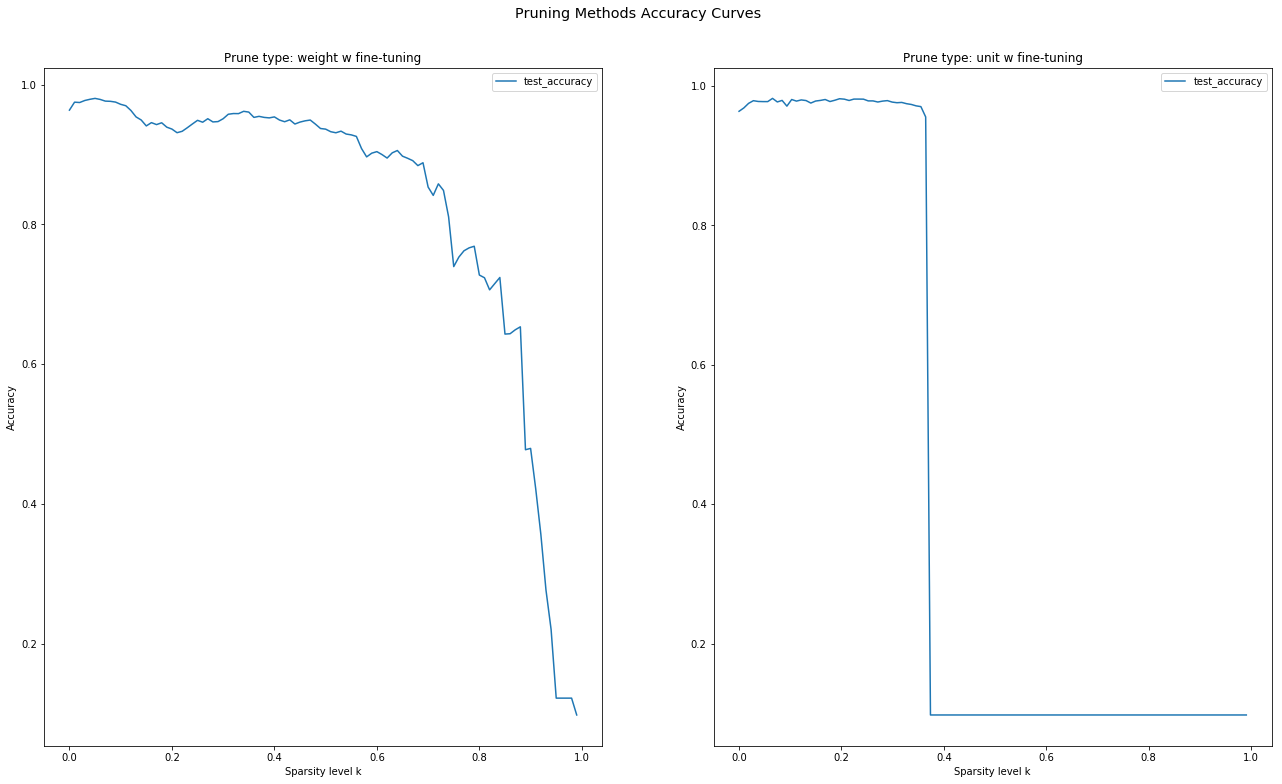

In [0]:
plot_pruning_curves(accs2,fine_tune='w')

In [0]:
### Insights 

 - We found that during early pruning steps, low sparisty level k, we saw slight gains in accuracy. This can be explained by pruning ability to reduce overfitting and thus benefit generalisation on the validation set. The slight increase in performance was typically followed by a gradual decrease in model performance. We can see weight pruning to be the most stable of the two methods, whilst unit pruning seemed to be fairly unstable, which is what we would expect from removing large numbers of units compared to indiviudal weights. 
 
 - Additional experiments were conducted without fine-tuning, which led to steady decreases in accuracy, as well as performance reduced to the same accuracy as guessing (0.09% acc) as early as ~k=0.2 .